In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import numpy as np

In [41]:
df = pd.read_csv(r'/KDDTrain+.txt')
df.head()

,0,tcp,ftp_data,SF,491,0.1,0.2,0.3,0.4,0.5,...,0.17,0.03,0.17.1,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal,20
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [42]:
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'difficulty_level'
]

In [43]:
df.columns = column_names

In [44]:
attack_categories = {
    'DOS': ['neptune', 'back', 'smurf', 'pod', 'teardrop', 'land', 'apache2', 'udpstorm', 'processtable', 'mailbomb'],
    'Probe': ['ipsweep', 'nmap', 'portsweep', 'satan', 'mscan', 'saint'],
    'R2L': ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'xsnoop', 'httptunnel', 'snmpguess', 'snmpgetattack', 'sendmail'],
    'U2R': ['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'sqlattack', 'xterm', 'ps'],
    'Normal': ['normal']
}

In [45]:
def get_attack_category(attack):
    for category, attacks in attack_categories.items():
        if attack in attacks:
            return category
    return 'Other'

In [48]:
label_encoders = {}
categorical_columns = ['protocol_type', 'service', 'flag', 'attack_type']

In [49]:
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    train_df[column] = label_encoders[column].fit_transform(train_df[column])

In [50]:
X = train_df.drop(['attack_type', 'attack_category', 'difficulty_level'], axis=1)
y = train_df['attack_type']

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
print("Class distribution before resampling:")
print(y_train.value_counts())

Class distribution before resampling:
attack_type
11    53956
9     32976
17     2884
5      2856
15     2348
18     2095
10     1195
0       755
21      714
20      696
14      165
3        39
1        23
6        16
22       16
4         9
2         8
16        8
7         6
8         6
13        3
12        2
19        1
Name: count, dtype: int64


In [53]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [54]:
print("Class distribution after resampling:")
print(pd.Series(y_train_resampled).value_counts())

Class distribution after resampling:
attack_type
9     53956
11    53956
5     53956
17    53956
20    53956
15    53956
0     53956
14    53956
10    53956
18    53956
6     53956
3     53956
21    53956
1     53956
2     53956
16    53956
7     53956
8     53956
22    53956
4     53956
13    53956
12    53956
19    53956
Name: count, dtype: int64


In [55]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [56]:
y_pred = rf_classifier.predict(X_val)

In [69]:
accuracy = np.mean(y_pred == y_val)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9984


In [57]:
print("Classification Report:")
print(classification_report(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       201
           1       0.83      0.71      0.77         7
           3       1.00      0.79      0.88        14
           4       1.00      1.00      1.00         2
           5       1.00      0.99      0.99       743
           6       0.67      1.00      0.80         2
           7       0.00      0.00      0.00         3
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00      8238
          10       0.99      0.99      0.99       298
          11       1.00      1.00      1.00     13386
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00        36
          15       1.00      1.00      1.00       583
          16       0.00      0.00      0.00         2
          17       1.00      0.99      0.99       749
    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [58]:
cm = confusion_matrix(y_val, y_pred)

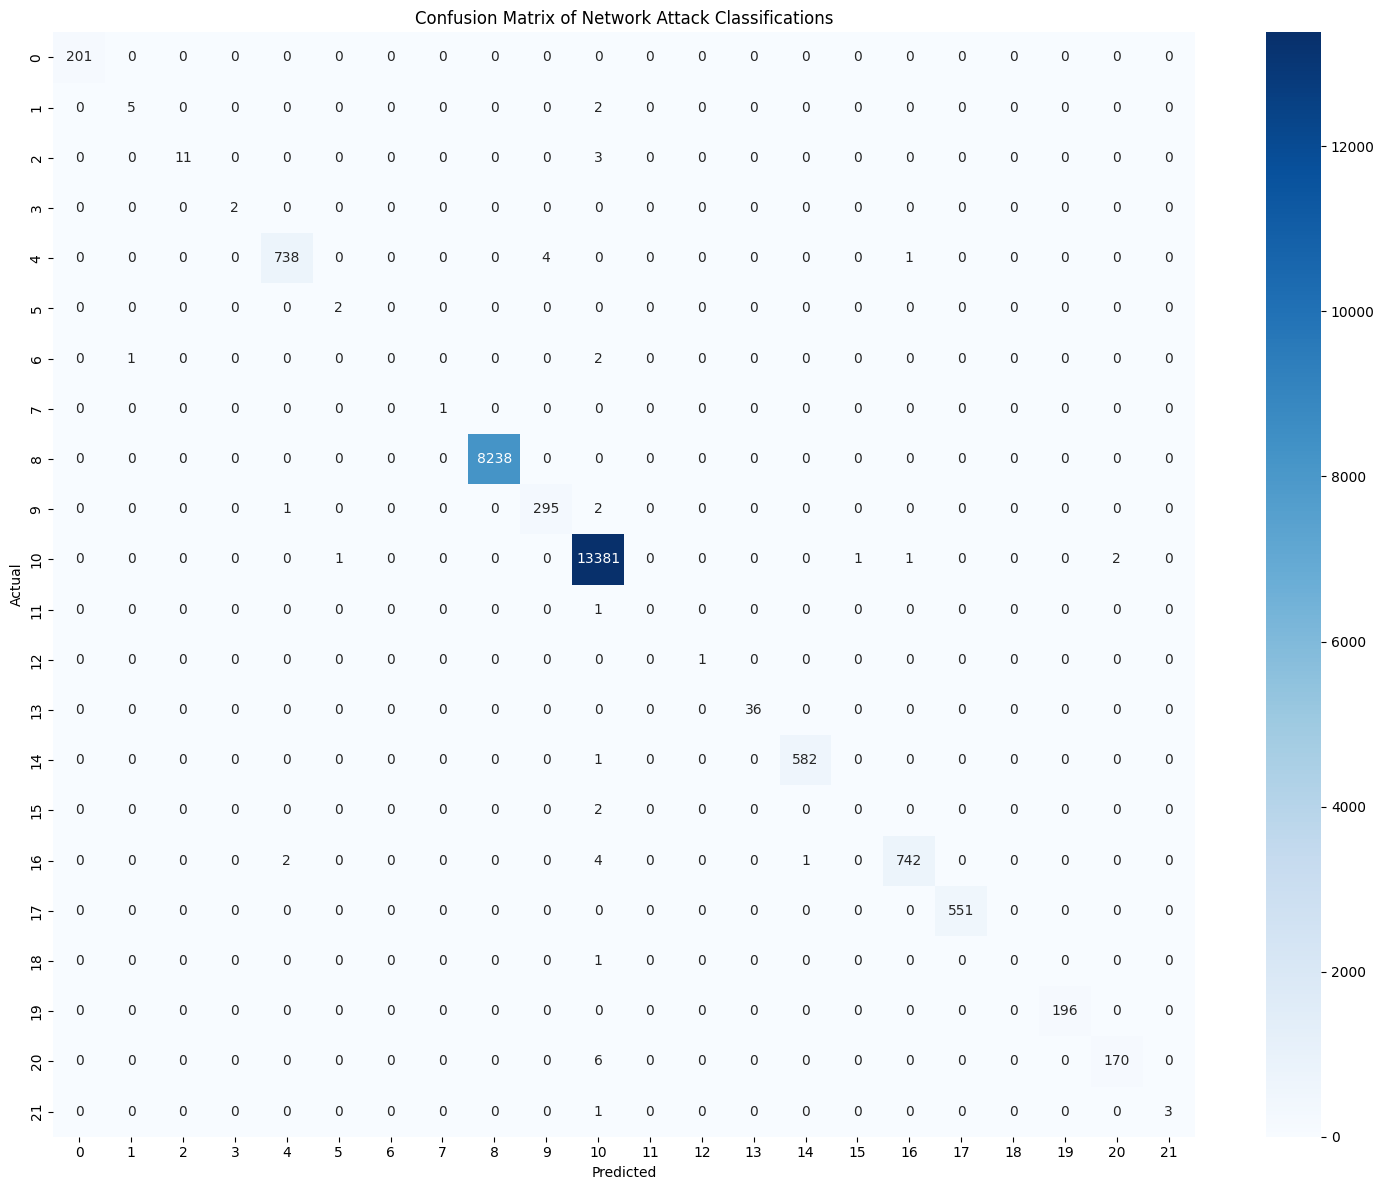

In [66]:
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Network Attack Classifications')

plt.tight_layout()
plt.show()

In [67]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_classifier.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)


In [68]:
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
                        feature  importance
4                     src_bytes    0.096368
5                     dst_bytes    0.068208
2                       service    0.057856
32           dst_host_srv_count    0.051913
7                wrong_fragment    0.049161
31               dst_host_count    0.044236
36  dst_host_srv_diff_host_rate    0.043436
35  dst_host_same_src_port_rate    0.035841
22                        count    0.034081
0                      duration    0.033417


In [104]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the training dataset
train_df = pd.read_csv(r'/KDDTrain+.txt')

# Rename columns (same as test data)
train_df.columns = column_names

# Create attack categories for the training data
train_df['attack_category'] = train_df['attack_type'].apply(get_attack_category)

# Load the test dataset
test_df = pd.read_csv(r'/KDDTest+.txt')

# Rename columns (same as training data)
test_df.columns = column_names

# Create attack categories for the test data
test_df['attack_category'] = test_df['attack_type'].apply(get_attack_category)

# Function to standardize categorical data
def standardize_data(df, columns):
    for column in columns:
        # Convert to string and fill NaN values
        df[column] = df[column].astype(str).str.lower().str.strip().fillna('unknown')
    return df

# Standardize both training and test datasets
categorical_columns = ['protocol_type', 'service', 'flag', 'attack_type']  # Update with your actual categorical columns
train_df = standardize_data(train_df, categorical_columns)
test_df = standardize_data(test_df, categorical_columns)

# Initialize label encoders for categorical columns (use the same encoders as before)
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    label_encoders[column].fit(train_df[column])  # Fit on training data

# Function to transform with handling for unseen labels
def transform_with_unknown(encoder, data):
    transformed_data = []
    for val in data:
        if val in encoder.classes_:
            transformed_data.append(encoder.transform([val])[0])
        else:
            print(f"Unrecognized value: {val}")  # Debugging output
            transformed_data.append(-1)  # Assign a default value for unseen labels
    return np.array(transformed_data)

# Inspect unique values in categorical columns of the test dataset before transformation
for column in categorical_columns:
    print(f"Unique values in test column '{column}' before transformation:")
    print(test_df[column].unique())

# Transform the test data
for column in categorical_columns:
    test_df[column] = transform_with_unknown(label_encoders[column], test_df[column])

# Check unique values in categorical columns of the test dataset after transformation
for column in categorical_columns:
    print(f"Unique values in test column '{column}' after transformation:")
    print(test_df[column].unique())

# Separate features and target for the test data
X_test = test_df.drop(['attack_type', 'attack_category', 'difficulty_level'], axis=1)
y_test = test_df['attack_type']

# Make predictions on the test set
y_test_pred = rf_classifier.predict(X_test)

# Calculate accuracy on the test set
test_accuracy = np.mean(y_test_pred == y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print classification report for the test set
# Specify the labels parameter to match the unique classes in predictions
unique_classes = np.unique(y_test_pred)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred, labels=unique_classes))

# Create confusion matrix for the test set
cm_test = confusion_matrix(y_test, y_test_pred)

# Create a figure

Unique values in test column 'protocol_type' before transformation:
['tcp' 'icmp' 'udp']
Unique values in test column 'service' before transformation:
['private' 'ftp_data' 'eco_i' 'telnet' 'http' 'smtp' 'ftp' 'ldap' 'pop_3'
 'courier' 'discard' 'ecr_i' 'imap4' 'domain_u' 'mtp' 'systat' 'iso_tsap'
 'other' 'csnet_ns' 'finger' 'uucp' 'whois' 'netbios_ns' 'link' 'z39_50'
 'sunrpc' 'auth' 'netbios_dgm' 'uucp_path' 'vmnet' 'domain' 'name' 'pop_2'
 'http_443' 'urp_i' 'login' 'gopher' 'exec' 'time' 'remote_job' 'ssh'
 'kshell' 'sql_net' 'shell' 'hostnames' 'echo' 'daytime' 'pm_dump' 'irc'
 'netstat' 'ctf' 'nntp' 'netbios_ssn' 'tim_i' 'supdup' 'bgp' 'nnsp' 'rje'
 'printer' 'efs' 'x11' 'ntp_u' 'klogin' 'tftp_u']
Unique values in test column 'flag' before transformation:
['rej' 'sf' 'rsto' 's0' 'rstr' 'sh' 's3' 's2' 's1' 'rstos0' 'oth']
Unique values in test column 'attack_type' before transformation:
['neptune' 'normal' 'saint' 'mscan' 'guess_passwd' 'smurf' 'apache2'
 'satan' 'buffer_overflow